# Anomaly Detection v3.1

## Note:
It is recommended to run the code using a GPU. To do this, go to Runtime > Change runtime type > Hardware Accelerator > select GPU.

It may be the case that a GPU is not available, in which case, use a default CPU ("None" hardware accelerator). The code will still work without a GPU, but may run much slower.

### Contributers:
Jason Ding

## Pre-requisites

In the following cells, we are installing and importing the necessary libaries and downloading the classification model.

In [172]:
!wget https://github.com/hendrycks/outlier-exposure/raw/master/CIFAR/snapshots/baseline/cifar10_wrn_baseline_epoch_99.pt
!wget https://raw.githubusercontent.com/hendrycks/pre-training/master/robustness/adversarial/models/wrn_with_pen.py
!pip3 install torchvision==0.12.0

--2022-08-24 17:51:17--  https://github.com/hendrycks/outlier-exposure/raw/master/CIFAR/snapshots/baseline/cifar10_wrn_baseline_epoch_99.pt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hendrycks/outlier-exposure/master/CIFAR/snapshots/baseline/cifar10_wrn_baseline_epoch_99.pt [following]
--2022-08-24 17:51:17--  https://raw.githubusercontent.com/hendrycks/outlier-exposure/master/CIFAR/snapshots/baseline/cifar10_wrn_baseline_epoch_99.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9037421 (8.6M) [application/octet-stream]
Saving to: ‘cifar10_wrn_baseline_epoch_99.pt.2’

cifar10_wrn_baselin 

In [173]:
import torch
import math
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision import datasets
import numpy as np
import torch.nn.functional as F
import sklearn.metrics as sk
from wrn_with_pen import WideResNet

prefetch = 2

## Model and Data Loading

In the following cells, we are loading the CIFAR-10 model. Additionally, we are retrieving CIFAR-10 and out-of-distribution datasets.

In [174]:
# Load CIFAR-10 model

net = WideResNet(depth=40, num_classes=10, widen_factor=2, dropRate=0.3)

if torch.cuda.is_available():
    net.load_state_dict(torch.load('cifar10_wrn_baseline_epoch_99.pt'))
    net.eval()
    net.cuda()
else:
    net.load_state_dict(torch.load('cifar10_wrn_baseline_epoch_99.pt', map_location=torch.device('cpu')))
    net.eval()

In [175]:
# /////////////// Loading Datasets ///////////////
mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

# /////////////// CIFAR-10 ///////////////

data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

cifar_10_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=data_transform
)

cifar10_data = cifar_10_data
cifar10_loader = torch.utils.data.DataLoader(cifar10_data, batch_size=200, shuffle=False,
                                          num_workers=prefetch, pin_memory=True)
ood_num_examples = len(cifar10_data) // 5

# /////////////// Rademacher Noise ///////////////

dummy_targets = torch.ones(ood_num_examples)
ood_data = torch.from_numpy(np.random.binomial(
    n=1, p=0.5, size=(ood_num_examples, 3, 32, 32)).astype(np.float32)) * 2 - 1
rademacher_ood_data = torch.utils.data.TensorDataset(ood_data, dummy_targets)
rademacher_ood_loader = torch.utils.data.DataLoader(rademacher_ood_data, batch_size=200, shuffle=True)

# /////////////// SVHN ///////////////

data_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize(mean, std)])

svhn_ood_data = torchvision.datasets.SVHN(root = "data", 
                          split="test",
                          transform = data_transform, 
                          download = True)

svhn_ood_loader = torch.utils.data.DataLoader(svhn_ood_data, batch_size=200, shuffle=True,
                                         num_workers=prefetch, pin_memory=True)

# /////////////// DTD ///////////////

# data_transform = transforms.Compose([transforms.Resize(32), transforms.CenterCrop(32),
#                                      transforms.ToTensor(), transforms.Normalize(mean, std)])

# dtd_ood_data = torchvision.datasets.DTD(root = "data", 
#                           split="test",
#                           transform = data_transform, 
#                           download = True)

# dtd_ood_loader = torch.utils.data.DataLoader(dtd_ood_data, batch_size=200, shuffle=True,
#                                          num_workers=prefetch, pin_memory=True)

# /////////////// CIFAR-100 ///////////////

data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

cifar100_ood_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=data_transform
)

cifar100_ood_loader = torch.utils.data.DataLoader(cifar100_ood_data, batch_size=200, shuffle=True,
                                         num_workers=prefetch, pin_memory=True)

Files already downloaded and verified
Using downloaded and verified file: data/test_32x32.mat
Files already downloaded and verified


## General Functions

The following cells define functions that we will use in the rest of the code. You do not need to do anything here.

In [176]:
concat = lambda x: np.concatenate(x, axis=0)
to_np = lambda x: x.data.cpu().numpy()

'''
Calculates the anomaly scores for a portion of the given dataset. 
If a GPU is not available, will run on a smaller fraction of the
dataset, so that calculations will be faster.

loader: A DataLoader that contains the loaded data of a dataset
anomaly_score_calculator: A function that takes in the output 
                          logit of a batch of data and/or the 
                          penultimate.
model_net: The classifier model.
usePenultimate: True if anomaly_score_calculator needs the 
                penultimate as a parameter. False otherwise.
'''
def get_ood_scores(loader, anomaly_score_calculator, model_net, use_penultimate = False):
    _score = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            if torch.cuda.is_available():
                fraction = 200
            else:
                fraction = 1000
            if batch_idx >= ood_num_examples // fraction:
                break

            if torch.cuda.is_available():
                data = data.cuda()

            output = model_net(data)

            if use_penultimate:
                score = anomaly_score_calculator(output[0], output[1])
            else:
                score = anomaly_score_calculator(output[0])
            _score.append(score)

    return concat(_score).copy()

In [177]:
# /////////////// Printing Results ///////////////
all_anomaly_results = {}

'''
Returns and prints out the AUROC score of a dataset.

ood_loader: A DataLoader that contains the loaded data of a dataset
anomaly_score_calculator: A function that takes in the output 
                          logit of a batch of data and/or the 
                          penultimate.
model_net: The classifier model.
usePenultimate: True if anomaly_score_calculator needs the 
                penultimate as a parameter. False otherwise.
'''
def get_and_print_results(ood_loader, anomaly_score_calculator, model_net, use_penultimate):
    out_score = get_ood_scores(ood_loader, anomaly_score_calculator, model_net, use_penultimate = use_penultimate)
    auroc = get_auroc(out_score, in_score)
    print('AUROC: \t\t\t{:.2f}'.format(100 * auroc) + "%")
    return auroc

'''
Prints out the AUROC score of all the OOD datasets. The results 
will be appended to global variable all_anomaly_results, which 
is used later for display purposes.

anomaly_score_calculator: A function that takes in the output 
                          logit of a batch of data and/or the 
                          penultimate.
anomaly_score_name: The name of the anomaly score method.
model_net: The classifier model.
model_name: The name of the classifier model.
usePenultimate: True if anomaly_score_calculator needs the 
                penultimate as a parameter. False otherwise.
'''
def print_all_results(anomaly_score_calculator, anomaly_score_name, model_net, model_name = "default_model", use_penultimate = False):
    global in_score, all_anomaly_results
    in_score = get_ood_scores(cifar10_loader, anomaly_score_calculator, model_net, use_penultimate)
    results = []

    print('Rademacher Noise Detection')
    auroc = get_and_print_results(rademacher_ood_loader, anomaly_score_calculator, model_net, use_penultimate)
    results.append(auroc)

    print('\nSVHN Detection')
    auroc = get_and_print_results(svhn_ood_loader, anomaly_score_calculator, model_net, use_penultimate)
    results.append(auroc)

    # print('\nDTD Detection')
    # auroc = get_and_print_results(dtd_ood_loader, anomaly_score_calculator, model_net, use_penultimate)
    # results.append(auroc)

    print('\nCIFAR-100 Detection')
    auroc = get_and_print_results(cifar100_ood_loader, anomaly_score_calculator, model_net, use_penultimate)
    results.append(auroc)

    average = sum(results) / len(results)
    results.append(average)

    if not model_name in all_anomaly_results:
        all_anomaly_results[model_name] = {}
    all_anomaly_results[model_name][anomaly_score_name] = results

## Implement AUROC Score
Fill in the get_auroc score. We will use this function in order to calculate the AUROC score of an out-of-distribution dataset.

It may be helpful to use the sklearn.metrics.roc_auc_score() function. Both _pos and _neg should be used.

In [178]:
import numpy as np
import matplotlib.pyplot as plt
'''
Calculates the AUROC score of a OOD dataset.

_pos: an array of anomoly scores of the OOD dataset
_neg: an array of anomoly scores of images in the CIFAR-10 dataset
return: The AUROC score the data in decimal form
'''
def get_auroc(_pos, _neg):
    ############################################################################
    # TODO:  Calculate the AUROC score.                                        #
    ############################################################################

    pos = _pos
    neg = _neg
    pos = np.array(pos)
    neg = np.array(neg)
    pos = np.reshape(pos, (pos.shape[0], 1))
    neg = np.reshape(neg, (neg.shape[0], 1))
    pos = np.concatenate((pos, np.ones((pos.shape[0], 1))), axis=1)
    neg = np.concatenate((neg, np.zeros((neg.shape[0], 1))), axis=1)
    data = np.concatenate((pos, neg), axis=0)
    data = data[data[:, 0].argsort()]
    tp = np.cumsum(data[:, 1])
    fp = np.cumsum(1 - data[:, 1])
    tp = tp / tp[-1]
    fp = fp / fp[-1]
    auroc_score = np.trapz(tp, fp)

    plt.plot(fp, tp)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    

    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    return auroc_score

## Implement Anomaly Score Calculators
Fill in the folllowing functions which calculate the anomaly score given the model's output for a batch of data (the output will contain one logit per image in the batch).

The following equations show how the logits should be transformed in order to get the anomaly score.

Max Logit Equation: <br>
$\text{Score}=-\text{max} l_k$

Max Softmax Equation: <br>
$\text{Score}=-\text{max} p(y=k|x)$

Cross Entropy Anomaly Equation: <br>
$\text{Score} = \bar{l}-\text{log}∑_{c=1}^{\text{num_classes}}e^{l_c}$

In [179]:
# /////////////// Anomaly Score Calculators ///////////////

'''
Calculates the max logit anomaly score of a batch of outputs.

output: The model's output for a batch of data.
'''
def max_logit_anomaly_score(output):
    ############################################################################
    # TODO: Calculate the max logit anomaly score (returning a numpy array).   #
    ############################################################################

    score, _ = torch.max(output, axis=1)
    score = score.cpu().numpy()



    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    return score

'''
Calculates the max softmax anomaly score of a batch of outputs.

output: The model's output for a batch of data.
'''
def max_softmax_anomaly_score(output):
    ############################################################################
    # TODO: Calculate the max softmax anomaly score (returning a numpy array). #
    ############################################################################

    # get the max softmax for each image

    softmax = torch.exp(output) / torch.sum(torch.exp(output), axis=1, keepdims=True)
    max_softmax, _ = torch.max(softmax, axis=1)
    max_softmax = max_softmax.cpu().numpy()




      

    

    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    return max_softmax

'''
Calculates the cross entropy anomaly score of a batch of outputs.

output: The model's output for a batch of data.
'''
def cross_entropy_anomaly_score(output):
    ############################################################################
    # TODO: Calculate the cross entropy anomaly score (returning a numpy array).#
    ############################################################################
    # get the cross entropy for each image



    l_hat = torch.mean(output, axis = 1)
    exp_output = torch.exp(output)
    sum_exp_output = torch.sum(exp_output, axis = 1)
    log_sum = torch.log(sum_exp_output)
    cross_entropy = l_hat - log_sum
    #softmax = torch.exp(output) / torch.sum(torch.exp(output), axis=1, keepdims=True)

    #cross_entropy = -torch.log(softmax)
    # convert to numpy array
    #cross_entropy = cross_entropy.cpu().numpy()
    #cross_entropy = np.mean(cross_entropy, axis=1)

    cross_entropy = -cross_entropy.cpu().numpy()


    

    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    return cross_entropy

## Print AUROC Results

Run the following cells in order to see how well each of the anomaly score calculators do on the OOD datasets.

======= Max Logit AUROC Scores =======
Rademacher Noise Detection


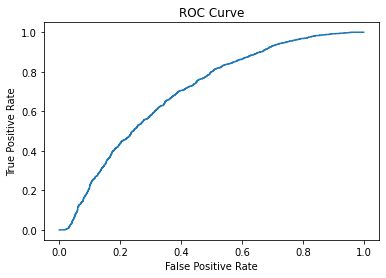

AUROC: 			69.76%

SVHN Detection


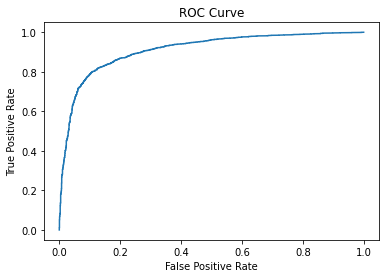

AUROC: 			91.10%

CIFAR-100 Detection


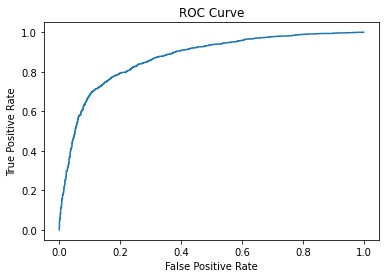

AUROC: 			87.11%


In [180]:
print("======= Max Logit AUROC Scores =======")
print_all_results(max_logit_anomaly_score, "Max Logit", net)

======= Max Softmax AUROC Scores =======
Rademacher Noise Detection


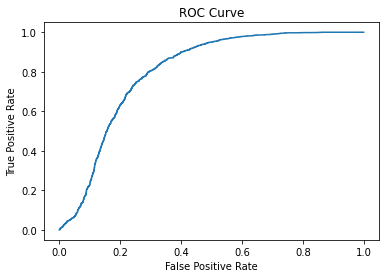

AUROC: 			80.01%

SVHN Detection


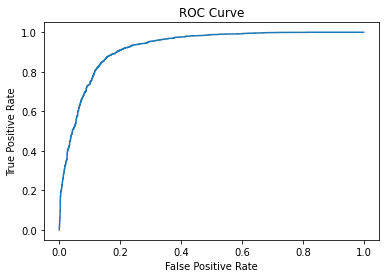

AUROC: 			92.21%

CIFAR-100 Detection


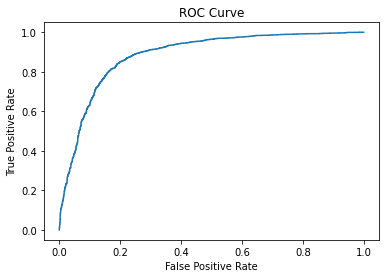

AUROC: 			88.52%


In [181]:
print("======= Max Softmax AUROC Scores =======")
print_all_results(max_softmax_anomaly_score, "Max Softmax", net)

======= Cross Entropy AUROC Scores =======
Rademacher Noise Detection


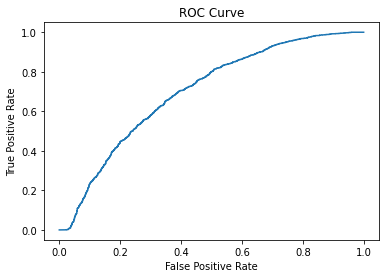

AUROC: 			69.79%

SVHN Detection


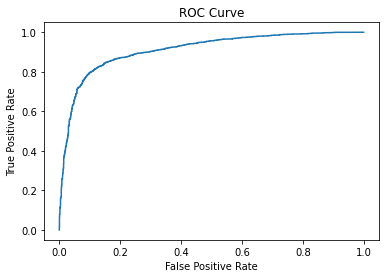

AUROC: 			91.02%

CIFAR-100 Detection


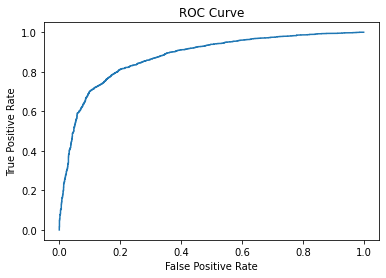

AUROC: 			87.56%


In [182]:
print("======= Cross Entropy AUROC Scores =======")
print_all_results(cross_entropy_anomaly_score, "Cross Entropy", net)

## Implement ViM

We will now implement virtual-logit matching (ViM). ViM works by doing the following. 

ViM first considers the **principal space** ($P$) of the features obtained by passing the training data (CIFAR-10) through to just before the final fully-connected layer. These features are then centered at the origin of a new coordinate system (defined by `u` in our code below). Let us use the 12 most significant principal components of these features for our principal space.

ViM calculates **alpha** ($\alpha$) by projecting the training data's features onto the space orthogonal to the prinicpal space ($P^\perp$). This projection is known as the **residual** ($x^{P^\perp}$). HINT: You may find it helpful to use np.linalg.svd to find the principal components (or you can use eignvalues and eigenvectors). The space orthogonal to the principle space can be found simply by taking the remaining principal components (i.e. all PCs apart from the first 12).

Alpha is then calculated by the following equation:
> $\alpha := \frac{∑^k_{i=1}\text{max}_{j=1,...,C}\{l^i_j\}}{∑^K_{i=1}\| x_i^{P\perp} \|}$

In other words, alpha is the sum of each logit's maximum value, divided by the sum of the norms of each feature's residuals.

Your calculated alpha in this part should be around 16.16.


In [183]:
# You may find the following functions useful.
from numpy.linalg import pinv, norm
from scipy.special import logsumexp
from sympy import Matrix
import scipy

_score = []
to_np = lambda x: x.data.cpu().numpy()
concat = lambda x: np.concatenate(x, axis=0)

# Extraction fully connected layer's weights and biases
w, b = net.fc.weight.cpu().detach().numpy(), net.fc.bias.cpu().detach().numpy()
# Origin of a new coordinate system of feature space to remove bias
u = -np.matmul(pinv(w), b)

'''
Calculates and returns the space orthogonal to the principal space (principal_space_perp)
and alpha values given the training data the model used.


training_data_loader: A DataLoader that contains the loaded data of a 
                      training dataset.
model_net: The classifier model.
verbose: If true, will print out the alpha value.
return: Returns the alpha value.
'''
def compute_ViM_principal_space_perp_and_alpha(training_data_loader, model_net, verbose = False):
    result = []

    # Getting the first batch of the training data to calculate principal_space_perp and alpha
    training_data, target = next(iter(training_data_loader))
    if torch.cuda.is_available():
        training_data = training_data.cuda()

    result = model_net(training_data)
    logit = result[0] # Logits (values before softmax)
    penultimate = result[1] # Features/Penultimate (values before fully connected layer)

    logit_id_train = logit.cpu().detach().numpy().squeeze()
    feature_id_train = penultimate.cpu().detach().numpy().squeeze()

    ############################################################################
    # TODO:  Calculate the space orthogonal to the pricipal space and then     #
    # compute alpha.                                                           #
    ############################################################################
    if verbose:
        print('Computing principal_space_perp...')

    U, s, V = np.linalg.svd(feature_id_train - u)
    principal_space_perp = V[12:,:]
    feature_id_train_projected = np.matmul(feature_id_train, principal_space_perp.T)
    norms = np.sum(np.linalg.norm(feature_id_train_projected, axis=1))
    # calculate the maximum of every logit
    max_logit = np.max(logit_id_train, axis=1)
    # calculate the sum of every max logit
    max_logit_sum = np.sum(max_logit)

    alpha = max_logit_sum / norms

    
    if verbose:
        print('Computing alpha...')


    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    if verbose:
        print(f'alpha = {alpha}')

    return principal_space_perp, alpha

principal_space_perp, alpha = compute_ViM_principal_space_perp_and_alpha(cifar10_loader, net, verbose = True)

Computing principal_space_perp...
Computing alpha...
alpha = 16.15999412536621


## Implement ViM Anomaly Score Calculator

Now, implement the ViM anomaly score calculator. 

First, we want to project our penultimate/feature values onto principal_space_perp which we found before, which is called the residual. We multiply the norm of this residual by alpha to get what we call the **virtual logit score**. 

Next, we get what we call the **energy score** by taking LogSumExp of the logits. 

Finally, the outputted **anomaly score** is calculated by subtracting the virtual logit by the energy score.

$\text{vlogit}= \alpha \| {x^{P^\perp}} \|$\
$\text{energy} = \text{ln}\sum_{i=1}^C e^{l_i}$\
$\text{anomaly_score} = \text{vlogit} - \text{energy}$

======= ViM_anomaly_score_calculator =======
Rademacher Noise Detection


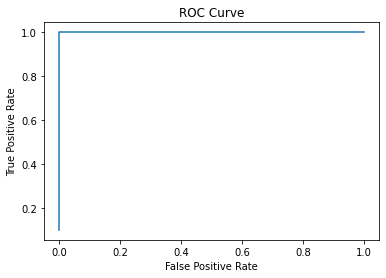

AUROC: 			100.00%

SVHN Detection


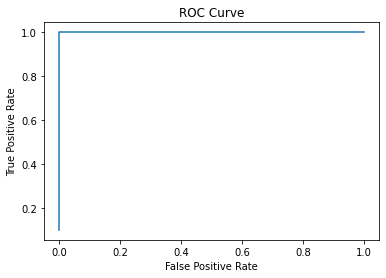

AUROC: 			100.00%

CIFAR-100 Detection


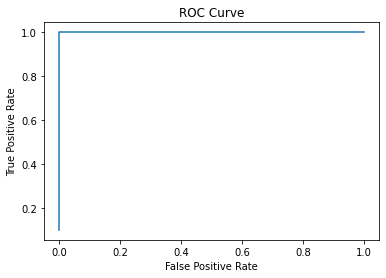

AUROC: 			100.00%


In [184]:
'''
Calculates the ViM anomaly score of a batch of outputs.

output: The model's output for a batch of data.
penultimate: The model's penultimate (feature values) for a batch of data.
'''
def ViM_anomaly_score_calculator(output, penultimate):
    logit_id_val = output.cpu().detach().numpy().squeeze()
    feature_id_val = penultimate.cpu().detach().numpy().squeeze()

    ############################################################################
    # TODO:  Calculate the anomaly score.                                      #
    ############################################################################

    U, s, V = np.linalg.svd(feature_id_val - u)
    principal_space_perp = V[12:,:]
    feature_id_train_projected = np.matmul(feature_id_val, principal_space_perp.T)
    norms = np.sum(np.linalg.norm(feature_id_train_projected, axis=1))
    # calculate the maximum of every logit
    max_logit = np.max(logit_id_val, axis=1)
    # calculate the sum of every max logit
    max_logit_sum = np.sum(max_logit)

    alpha = max_logit_sum / norms
   
    energy = np.log(np.sum(np.exp(logit_id_val)))
    def projector(M):
      return np.matmul(M, M.T)
    P = projector(principal_space_perp)
    norm = np.linalg.norm(feature_id_train_projected)
    vlogit = alpha * norm

    score_id = vlogit - energy



    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    
    return [score_id]

print("======= ViM_anomaly_score_calculator =======")
w, b = net.fc.weight.cpu().detach().numpy(), net.fc.bias.cpu().detach().numpy()
u = -np.matmul(pinv(w), b)
principal_space_perp, alpha = compute_ViM_principal_space_perp_and_alpha(cifar10_loader, net) # Making sure you have the correct ViM values before calculating the score 
print_all_results(ViM_anomaly_score_calculator, "ViM", net, use_penultimate = True)

## Compare Anomaly Score Results
Run the following cell to see how the different anomaly score calculators compare to each other for the OOD datasets. You should see that ViM is superior to other anomaly scores in all of the datasets except for CIFAR-10.

In [185]:
# ///////////////// Compare Results /////////////////

def get_results_max(model_name = "normal"):
    all_anomaly_results[model_name]["max"] = [0,0,0,0,0]
    for key in all_anomaly_results[model_name].keys():
        if (key != "max"):
            index = 0
            for score in all_anomaly_results[model_name][key]:
                all_anomaly_results[model_name]["max"][index] = \
                    max(score, all_anomaly_results[model_name]["max"][index])
                index += 1


def compare_all_results():
    for model_name in all_anomaly_results:
        to_be_printed = " " * (25 - len(model_name)) + model_name
        dataset_names = ["Rademacher", "SVHN", "CIFAR-100", "Average"]
        for name in dataset_names:
            to_be_printed += " | " + " "*(6-math.ceil(len(name)/2)) + \
                                name + " "*(6-math.floor(len(name)/2))

        print(to_be_printed)
        print("=" * (25 + len(dataset_names) * 15))

        get_results_max(model_name = model_name)
        for key in all_anomaly_results[model_name].keys():
            if (key != "max"):
                to_be_printed = " "*(25-len(key)) + key
                index = 0
                for result in all_anomaly_results[model_name][key]:
                    if (all_anomaly_results[model_name]["max"][index] == result):
                        result = "*" + '{:.2f}'.format(round(result * 100, 2)) + "%"
                    else:
                        result = '{:.2f}'.format(round(result * 100, 2)) + "%"
                    to_be_printed += " | " + " "*(6-math.ceil(len(result)/2)) + \
                                        result + " "*(6-math.floor(len(result)/2))
                    index += 1
                print(to_be_printed)
        print()

    print("\n* highlights the maximum AUROC Score for an OOD Dataset")

compare_all_results()

            default_model |  Rademacher  |     SVHN     |  CIFAR-100   |   Average   
                Max Logit |    69.76%    |    91.10%    |    87.11%    |    82.66%   
              Max Softmax |    80.01%    |    92.21%    |    88.52%    |    86.91%   
            Cross Entropy |    69.79%    |    91.02%    |    87.56%    |    82.79%   
                      ViM |   *100.00%   |   *100.00%   |   *100.00%   |   *100.00%  


* highlights the maximum AUROC Score for an OOD Dataset


## Data Augmentation

Now we will see if models trained using data augmentation methods for robustness help in OOD detection. 

We will load a CIFAR-10 model that used PixMix data augmentation during training, and see how it fares compared to the default model that did not use data augmentation.

In [186]:
!gdown 1mjIfbb3mfXXvAZ1sBnjotFr5yYFmLi68 # Downloading PixMix model
!gdown 1skZT6yplO-Sv4M8Ksgzx14cTY3H-HgOa # Downlaoding wideresnet class

Downloading...
From: https://drive.google.com/uc?id=1mjIfbb3mfXXvAZ1sBnjotFr5yYFmLi68
To: /content/checkpoint.pth.tar
100% 71.8M/71.8M [00:00<00:00, 271MB/s]
Downloading...
From: https://drive.google.com/uc?id=1skZT6yplO-Sv4M8Ksgzx14cTY3H-HgOa
To: /content/wideresnet_with_pen.py
100% 4.03k/4.03k [00:00<00:00, 7.17MB/s]


In [187]:
from wideresnet_with_pen import WideResNet as WideResNet2

In [188]:
# Loading the PixMix model

pixmix_net = WideResNet2(depth=40, num_classes=10, widen_factor=4, drop_rate=0.3)
pixmix_net = torch.nn.DataParallel(pixmix_net)

if torch.cuda.is_available():
    checkpoint = torch.load('checkpoint.pth.tar')
    pixmix_net.load_state_dict(checkpoint['state_dict'])
    net.eval()
    net.cuda()
else:
    checkpoint = torch.load('checkpoint.pth.tar', map_location=torch.device('cpu'))
    pixmix_net.load_state_dict(checkpoint['state_dict'])
    net.eval()

## PixMix Model Testing

Let us now test the PixMix model with the same anomaly score calculators we coded before.

======= Max Logit AUROC Scores =======
Rademacher Noise Detection


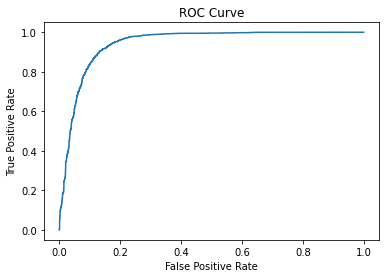

AUROC: 			94.21%

SVHN Detection


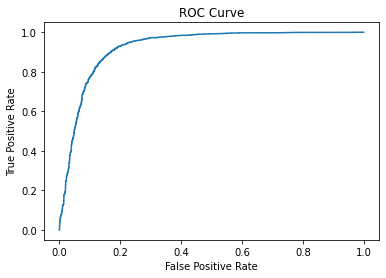

AUROC: 			92.37%

CIFAR-100 Detection


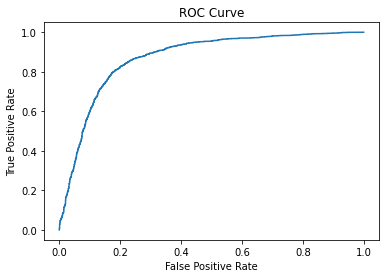

AUROC: 			87.05%


In [189]:
print("======= Max Logit AUROC Scores =======")
print_all_results(max_logit_anomaly_score, "Max Logit", pixmix_net, model_name = "pixmix_trained_model")

======= Max Softmax Probability AUROC Scores =======
Rademacher Noise Detection


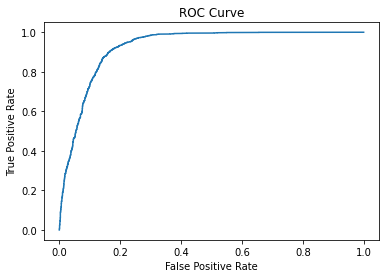

AUROC: 			92.56%

SVHN Detection


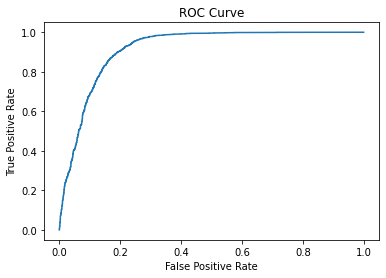

AUROC: 			91.46%

CIFAR-100 Detection


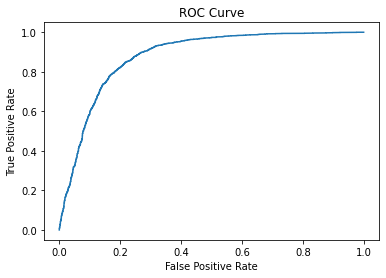

AUROC: 			87.93%


In [190]:
print("======= Max Softmax Probability AUROC Scores =======")
print_all_results(max_softmax_anomaly_score, "Max Softmax Probability", pixmix_net, model_name = "pixmix_trained_model")

======= Cross Entropy AUROC Scores =======
Rademacher Noise Detection


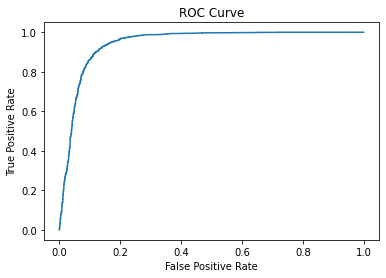

AUROC: 			94.32%

SVHN Detection


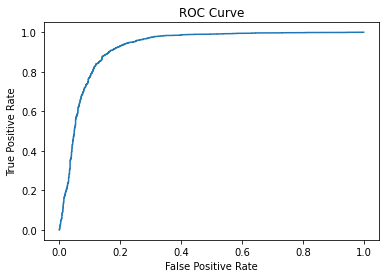

AUROC: 			92.35%

CIFAR-100 Detection


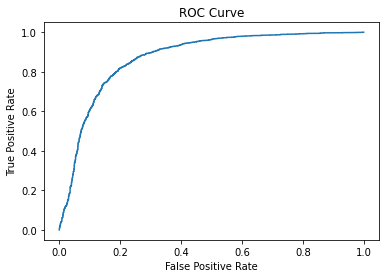

AUROC: 			87.24%


In [191]:
print("======= Cross Entropy AUROC Scores =======")
print_all_results(cross_entropy_anomaly_score, "Cross Entropy", pixmix_net, model_name = "pixmix_trained_model")

======= ViM_anomaly_score_calculator =======
Rademacher Noise Detection


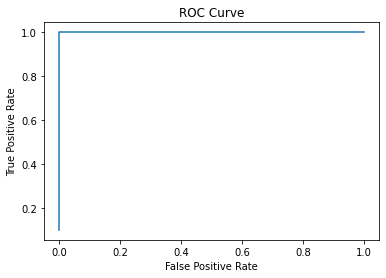

AUROC: 			100.00%

SVHN Detection


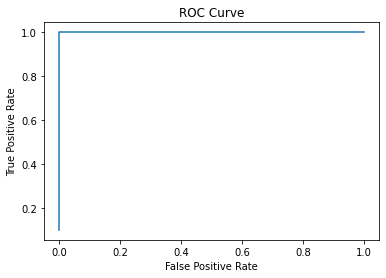

AUROC: 			100.00%

CIFAR-100 Detection


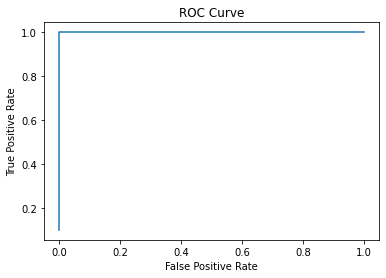

AUROC: 			100.00%


In [192]:
print("======= ViM_anomaly_score_calculator =======")
w, b = pixmix_net.module.fc.weight.cpu().detach().numpy(), pixmix_net.module.fc.bias.cpu().detach().numpy()
u = -np.matmul(pinv(w), b)
principal_space_perp, alpha = compute_ViM_principal_space_perp_and_alpha(cifar10_loader, pixmix_net)
print_all_results(ViM_anomaly_score_calculator, "ViM", pixmix_net, model_name = "pixmix_trained_model", use_penultimate = True)

## Compare No-data-augmentation Model vs PixMix Model

Let us now compare how the default model compared to the PixMix model by running the following cell. 

You should see that the PixMix model successfully helps us in OOD detection, and has a higher AUROC score (except for ViM).

In [193]:
compare_all_results()

            default_model |  Rademacher  |     SVHN     |  CIFAR-100   |   Average   
                Max Logit |    69.76%    |    91.10%    |    87.11%    |    82.66%   
              Max Softmax |    80.01%    |    92.21%    |    88.52%    |    86.91%   
            Cross Entropy |    69.79%    |    91.02%    |    87.56%    |    82.79%   
                      ViM |   *100.00%   |   *100.00%   |   *100.00%   |   *100.00%  

     pixmix_trained_model |  Rademacher  |     SVHN     |  CIFAR-100   |   Average   
                Max Logit |    94.21%    |    92.37%    |    87.05%    |    91.21%   
  Max Softmax Probability |    92.56%    |    91.46%    |    87.93%    |    90.65%   
            Cross Entropy |    94.32%    |    92.35%    |    87.24%    |    91.30%   
                      ViM |   *100.00%   |   *100.00%   |   *100.00%   |   *100.00%  


* highlights the maximum AUROC Score for an OOD Dataset


In [194]:
# Your output above should look similar to below